# Multi-resolution separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import healpy as hp
import pysm

from fgbuster.observation_helpers import get_instrument, get_sky
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
import fgbuster.separation_recipes as sr

From more basic examples you know that `basic_comp_sep` allows you to tile the sky in healpix pixels at a given `nside` and perform the fit of the spectral parameters independently for each tile. However, you potentially want to fit different parameters at different resolutions. You can achieve this with the `multi_res_comp_sep` utility function in `separation_recipes`. Here is an example of how it works.

## Simulate your frequency maps

In [2]:
nside = 8
sky = pysm.Sky(get_sky(nside, 'c1d0s0'))
instrument = pysm.Instrument(get_instrument('litebird', nside))
freq_maps = instrument.observe(sky, write_outputs=False)[0]
freq_maps = freq_maps[:, 1:]  # Select polarization

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0040.00 | 25.60 | 36.10 | 00.00 
0050.00 | 13.90 | 19.60 | 00.00 
0060.00 | 14.33 | 20.20 | 00.00 
0068.40 | 08.01 | 11.30 | 00.00 
0078.00 | 07.30 | 10.30 | 00.00 
0088.50 | 05.96 | 08.40 | 00.00 
0100.00 | 04.96 | 07.00 | 00.00 
0118.90 | 04.11 | 05.80 | 00.00 
0140.00 | 03.33 | 04.70 | 00.00 
0166.00 | 04.96 | 07.00 | 00.00 
0195.00 | 04.11 | 05.80 | 00.00 
0234.90 | 05.67 | 08.00 | 00.00 
0280.00 | 06.45 | 09.10 | 00.00 
0337.40 | 08.09 | 11.40 | 00.00 
0402.10 | 13.90 | 19.60 | 00.00 
Instrument attribute 'pixel_indices' not set.


## Define what you fit for
Create your sky model as a list of components

In [3]:
components = [CMB(), Dust(353.), Synchrotron(70., running=None, nu_pivot=70.)]

In [4]:
for comp in components:
    comp.defaults = [d*1.05 for d in comp.defaults] 

## Component separation
`multi_res_comp_sep` has almost the same signature of `basic_comp_sep`. The only difference is the `nside` parameter, which becomes `nsides`. It is no longer an integer but a list of integers, each specifying the resolution of a parameters.

In [5]:
nsides = [4, 1, 2, 0]

Which means that

In [6]:
for nside, param in zip(nsides, MixingMatrix(*components).params):
    print(f"{param} is fitted for at nside {nside}")

Dust.beta_d is fitted for at nside 4
Dust.temp is fitted for at nside 1
Synchrotron.beta_pl is fitted for at nside 2
Synchrotron.running is fitted for at nside 0


In [7]:
result = sr.multi_res_comp_sep(components, instrument, freq_maps, nsides=nsides)#, method='L-BFGS-B', options=dict(disp=True))                                                                                                                ))

Note that all the parameters are fitted simultaneously. This makes the maximization of the likelihood substantially more difficult. Consider tuning the parameters of the minimizer [``scipy.optimize.minimize``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

## Explore the results
Unlike `basic_comp_sep`, `res.x` is now a list — since the maps have different resolutions you can not stack them in an `ndarray` — but you access the maps of each parameters in the same way. 

Synchrotron.running -2.046154545129092e-06


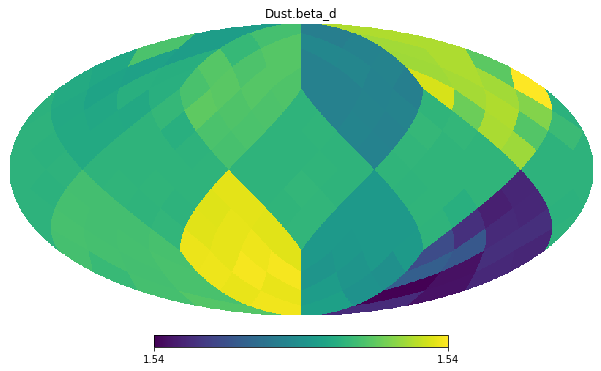

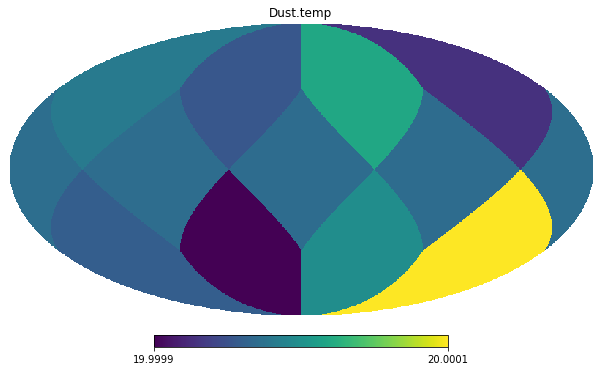

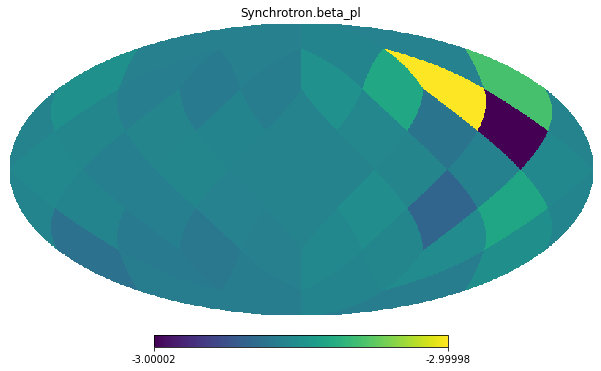

In [8]:
for par_x, par in zip(result.x, result.params):
    if len(par_x)>1:
        hp.mollview(par_x, title=par)
    else:
        print(par, par_x[0])



The amplitudes of the components are stacked in the ``s`` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case.

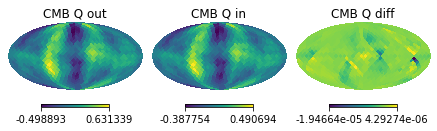

In [9]:
hp.mollview(result.s[0,0], title='CMB Q out', sub=(1, 3, 1))
hp.mollview(sky.cmb(100.)[1], title='CMB Q in', sub=(1, 3, 2))
hp.mollview(result.s[0,0] - sky.cmb(100.)[1]*pysm.convert_units('K_RJ', 'K_CMB', 100.), title='CMB Q diff', sub=(1, 3, 3))

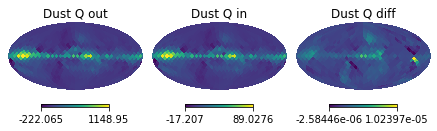

In [10]:
hp.mollview(result.s[1, 0], title='Dust Q out', sub=(1, 3, 1))
hp.mollview(sky.dust(353.)[1], title='Dust Q in', sub=(1, 3, 2))
hp.mollview(result.s[1, 0] - sky.dust(353.)[1]*pysm.convert_units('K_RJ', 'K_CMB', 353.), title='Dust Q diff', sub=(1, 3, 3))

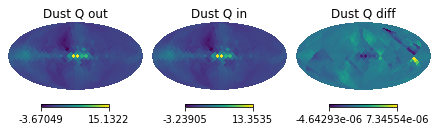

In [11]:
hp.mollview(result.s[2, 0], title='Dust Q out', sub=(1, 3, 1))
hp.mollview(sky.synchrotron(70.)[1], title='Dust Q in', sub=(1, 3, 2))
hp.mollview(result.s[2, 0] - sky.synchrotron(70.)[1]*pysm.convert_units('K_RJ', 'K_CMB', 70.), title='Dust Q diff', sub=(1, 3, 3))